# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data
data_folder = "data/"

training_file = ''.join([data_folder,'train.p'])
validation_file= ''.join([data_folder,'valid.p'])
testing_file = ''.join([data_folder,'test.p'])

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import numpy as np

# TODO: Number of training examples - take the first element of the shape tuple
n_train = X_train.shape[0]

# TODO: Number of validation examples - take the first element of the shape tuple
n_validation = X_valid.shape[0]

# TODO: Number of testing examples - take the first element of the shape tuple
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image? - take shape of first trainin example, X x Y x D where D is channel depth
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset - take the shape of the unique elements of y_train
n_classes = np.unique(y_train).shape

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = (43,)


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

In [7]:
# take in the signames csv to augment the vizualisation
import csv
with open("signnames.csv",'r') as f:
    signnames = list(csv.reader(f))
signnames = signnames[1:]
signnames[0]

['0', 'Speed limit (20km/h)']

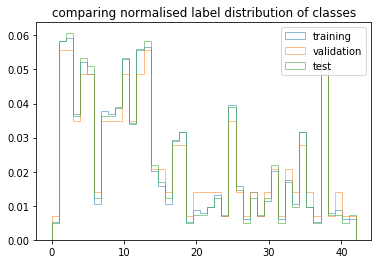

In [8]:
# Viz 1: Do Histogram of Classes in each data set 
plt.title("comparing normalised label distribution of classes")
plt.hist(y_train, bins=43, histtype="step", normed=True, label="training", alpha=0.5)
plt.hist(y_valid, bins=43, histtype="step", normed=True, label="validation", alpha=0.5)
plt.hist(y_test, bins=43, histtype="step", normed=True, label="test", alpha=0.5)
plt.legend(loc='upper right')

The histograms of each dataset showing count of label, shows that each label has a similar distribution in each dataset but that within a dataset, some labels are much more common than others. For example, #19 (dangerous curve to the left) verses #1 (30km/h speed limit). 

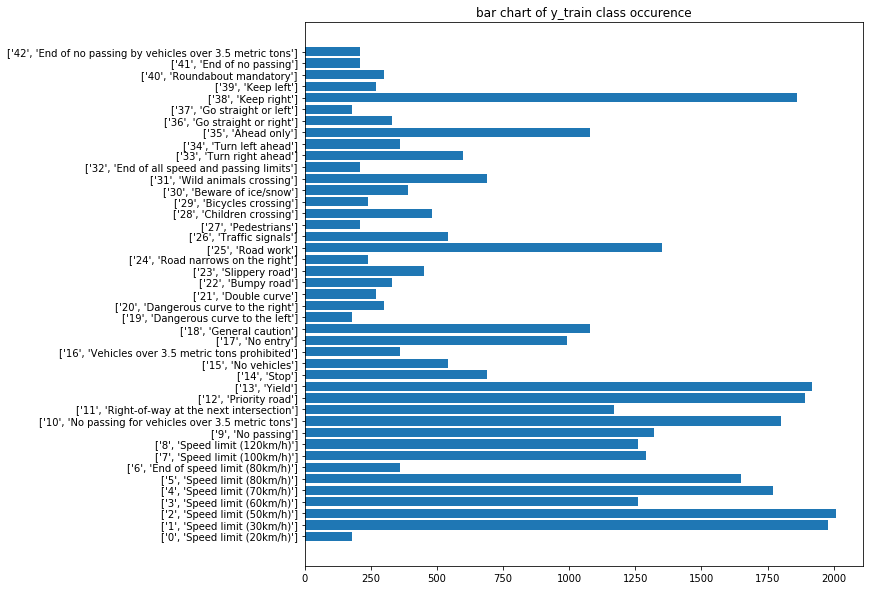

In [9]:
# show the class counts for training data
class_counts = np.unique(y_train, return_counts=True)
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("bar chart of y_train class occurence")
ax.barh(class_counts[0],class_counts[1])
ax.set_yticks(np.arange(len(class_counts[0])))
ax.set_yticklabels(signnames)
plt.show()

The bar chart shows the count of each sign in the training dataset. This leads to the idea of balancing the distribution of each sign through augmentation of the dataset using transformations. For example, with the speed limit signs, the 20kph sign occurs less than 250 times whereas each of the other speed limit signs occur more than 1250 times.

## Dataset manipulation

In this section, the training data will be transformed to assist ith feature extraction. This will create a pipeline that can then be used for validation and testing. The aim is to create an augmented (more data), balanced (even distribution of training examples) and normalised (pixel values normalised to zero mean) dataset for training, with the view that these actions will create a more robust model.

In [10]:
# new imports for further vizualisation and image processing
import skimage.color
import skimage.exposure
import skimage.transform
import random

In [11]:
# function to normalise image data
def img_normalise(data):
    """
        assumes numpy array of images
        returns transformed array
    """
    return (data - data.mean()) / np.std(X_train)

# create a normalised data set
X_train_norm = img_normalise(X_train)

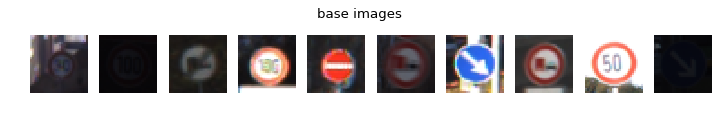

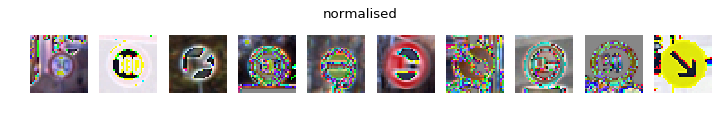

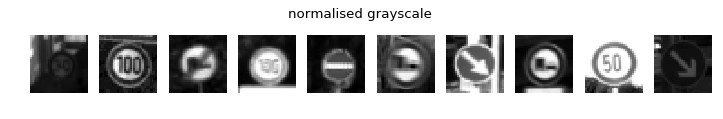

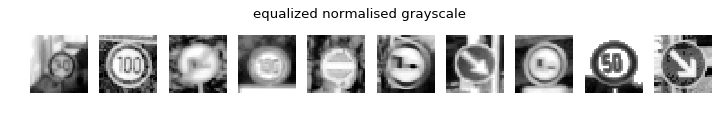

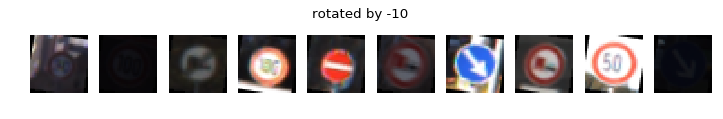

In [12]:
# create various transformed versions of the images to compare technique effectiveness for feature extraction

# get a common set of 10 indices
indices = []
for i in range(10):
    indices.append(random.randint(0,X_train_norm.shape[0]))
    
# base image    
fig = plt.figure(figsize=(11,1.5), dpi=80)
plt.suptitle('base images')
for i in indices:
    plt.subplot(1,10,indices.index(i)+1)
    plt.axis('off')
    plt.imshow(X_train[i])
    
fig = plt.figure(figsize=(11,1.5), dpi=80)
plt.suptitle('normalised')
for i in indices:
    plt.subplot(1,10,indices.index(i)+1)
    plt.axis('off')
    plt.imshow(X_train_norm[i])

fig = plt.figure(figsize=(11,1.5), dpi=80)
plt.suptitle('normalised grayscale')
for i in indices:
    plt.subplot(1,10,indices.index(i)+1)
    plt.axis('off')
    plt.imshow(skimage.color.rgb2grey(X_train_norm[i]),cmap='gray')

fig = plt.figure(figsize=(11,1.5), dpi=80)
plt.suptitle('equalized normalised grayscale')
for i in indices:
    plt.subplot(1,10,indices.index(i)+1)
    plt.axis('off')
    plt.imshow(skimage.exposure.equalize_hist(skimage.color.rgb2grey(X_train_norm[i])), cmap='gray')
    
fig = plt.figure(figsize=(11,1.5), dpi=80)
plt.suptitle('rotated by -10')
for i in indices:
    plt.subplot(1,10,indices.index(i)+1)
    plt.axis('off')
    plt.imshow(skimage.transform.rotate(X_train[i],-10))

The images above appear to show that equalized, normalised grayscale images make image features more discernable to the naked eye and so possibly to the image recognition network.

In [14]:
def extend_images(X,y):
    """
        function to create an extended dataset from an existing dataset whilst balancing the distribution of each image
        we're assuming here that the X array is 4D
        
        args: X - the image array; y - the labels for the image array
        returns: X_extended, y _extended - the concatenated original and extended images and labels
    """
    # get the y label class counts and discover the largest
    class_counts = np.unique(y_train, return_counts=True)
    max_counts = np.max(class_counts[1])
    extended_X = []
    # iterate the training data and create augmented images, if necessary
    for idx in range(X.shape[0]):
        
        # get the image's count of class
        idx_class_count = class_counts[1][y[idx]]
        
        # calculate how many times less than the max class the current image is
        dist_factor = idx_class_count / max_counts
        
        # if > 1 times difference, add images to the dataset
        if dist_factor < 0.75:
            dist_factor = int(1/dist_factor)
            for j in range(dist_factor):
                # use increasing degrees of rotation
                if (j % 2 == 0):
                    img = skimage.transform.rotate(X[idx],(j+1)*-5)
                else:
                    img = skimage.transform.rotate(X[idx],(j+1)*5)
                
                # is this the first additional image?
                if (idx == 0) and (j == 0):
                    extended_X.append(img)
                    extended_y = np.array([y[idx]])
                else:
                    extended_X.append(img)
                    extended_y = np.append(extended_y,y[idx])
                    
    extended_X = np.asarray(extended_X)
            
    return np.concatenate((X,extended_X)), np.concatenate((y,extended_y))

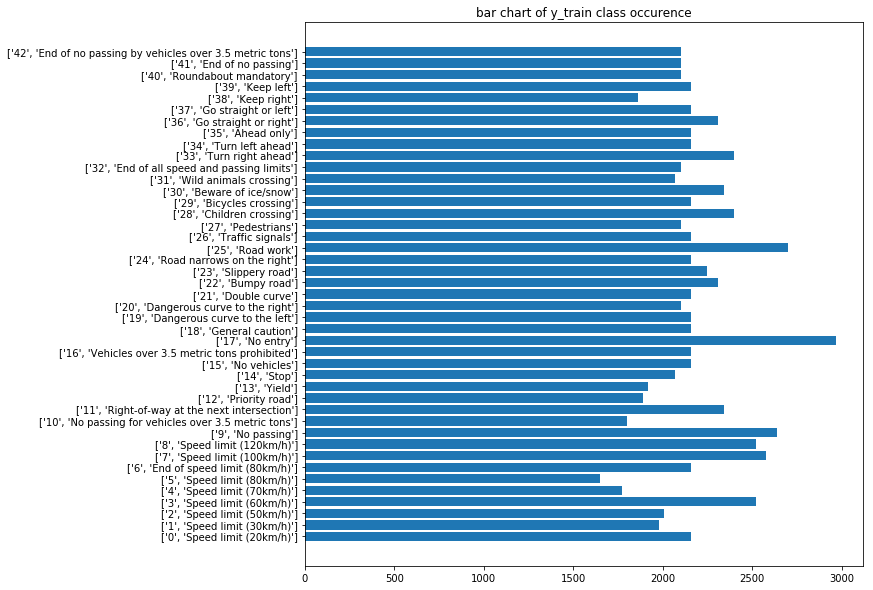

In [15]:
# create extended dataset
X_train_extended, y_train_extended = extend_images(X_train, y_train)
# show the class counts for training data
class_counts = np.unique(y_train_extended, return_counts=True)
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("bar chart of y_train class occurence")
ax.barh(class_counts[0],class_counts[1])
ax.set_yticks(np.arange(len(class_counts[0])))
ax.set_yticklabels(signnames)
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [16]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.
### the normalisation function is found a few code cells above here
X_train_norm = img_normalise(X_train_extended)
X_valid_norm = img_normalise(X_valid)

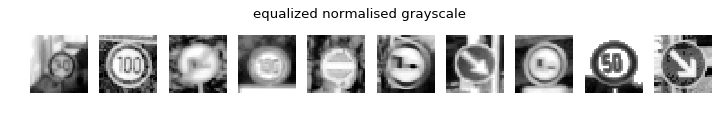

In [17]:
# should now take this normed version of the data and apply gray and equalise
X_train_equal = np.zeros((X_train_norm.shape[0],32,32))
X_valid_equal = np.zeros((X_valid_norm.shape[0],32,32))

for i in range(X_train_norm.shape[0]):
    X_train_equal[i] = skimage.exposure.equalize_hist(skimage.color.rgb2grey(X_train_norm[i]))

for i in range(X_valid_norm.shape[0]):
    X_valid_equal[i] = skimage.exposure.equalize_hist(skimage.color.rgb2grey(X_valid_norm[i]))

# vizualise the result...
fig = plt.figure(figsize=(11,1.5), dpi=80)
plt.suptitle('equalized normalised grayscale')
for i in indices:
    plt.subplot(1,10,indices.index(i)+1)
    plt.axis('off')
    plt.imshow(X_train_equal[i], cmap='gray')
    
X_train_equal = X_train_equal.reshape(X_train_equal.shape + (1,)) 
X_valid_equal = X_valid_equal.reshape(X_valid_equal.shape + (1,)) 

### Model Architecture

In [14]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [18]:
# shuffle the training data
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten


#X_train_norm, y_train = shuffle(X_train_norm, y_train_extended)
X_train_equal, y_train = shuffle(X_train_equal, y_train_extended)

# test run params containing various combinations of epoch and batch sizes
#test_run_params = [(10,128,0.001,1),(100,128,0.001,1),(100,256,0.001,0.8),(200,256,0.0003,0.5)]
test_run_params = [(200,256,0.0003,0.5)]

# defaults
EPOCHS = 200
BATCH_SIZE = 256
rate = 0.0003

In [20]:
# model 1: raw LeNet model adopted for normalised german traffic data
def LeNet(x, keep_prob, output_layer=None):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3 (or 1). Output = 28x28x6.
    #conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)
    if output_layer == 'conv1': return conv1

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation added dropout
    fc1    = tf.nn.relu(fc1)
    fc1    = tf.nn.dropout(fc1, keep_prob)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation. added drop out
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(fc2, keep_prob)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [21]:
#x = tf.placeholder(tf.float32, (None, 32, 32, 3))
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

# moved this to test run params 
#rate = 0.0003
keep_prob = tf.placeholder(tf.float32)
    
logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [22]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

# always pass keep_prob as 1.0 for evaluation
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [23]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.
for i in range(len(test_run_params)):
    EPOCHS = test_run_params[i][0]
    BATCH_SIZE = test_run_params[i][1]
    rate = test_run_params[i][2]
    k_prob = test_run_params[i][3]
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        #num_examples = len(X_train_norm)
        num_examples = len(X_train_equal)

        print("Training...")
        print(EPOCHS, BATCH_SIZE, rate, k_prob)
        print()
        for i in range(EPOCHS):
            #X_train_norm, y_train = shuffle(X_train_norm, y_train)
            X_train_equal, y_train = shuffle(X_train_equal, y_train)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                #batch_x, batch_y = X_train_norm[offset:end], y_train[offset:end]
                batch_x, batch_y = X_train_equal[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:k_prob})

            #validation_accuracy = evaluate(X_valid_norm, y_valid)
            if (i % 5 == 0 or i == EPOCHS):
                validation_accuracy = evaluate(X_valid_equal, y_valid)
                print("EPOCH {}, validation accuracy = {:.3f}".format(i+1, validation_accuracy))
                #print("Validation Accuracy = {:.3f}".format(validation_accuracy))
                #print()

        saver.save(sess, './lenet')
        print("Model saved")

Training...
200 256 0.0003 0.5

EPOCH 1, validation accuracy = 0.469
EPOCH 6, validation accuracy = 0.809
EPOCH 11, validation accuracy = 0.870
EPOCH 16, validation accuracy = 0.897
EPOCH 21, validation accuracy = 0.914
EPOCH 26, validation accuracy = 0.927
EPOCH 31, validation accuracy = 0.932
EPOCH 36, validation accuracy = 0.939
EPOCH 41, validation accuracy = 0.936
EPOCH 46, validation accuracy = 0.945
EPOCH 51, validation accuracy = 0.942
EPOCH 56, validation accuracy = 0.944
EPOCH 61, validation accuracy = 0.951
EPOCH 66, validation accuracy = 0.948
EPOCH 71, validation accuracy = 0.953
EPOCH 76, validation accuracy = 0.951
EPOCH 81, validation accuracy = 0.954
EPOCH 86, validation accuracy = 0.955
EPOCH 91, validation accuracy = 0.952
EPOCH 96, validation accuracy = 0.956
EPOCH 101, validation accuracy = 0.956
EPOCH 106, validation accuracy = 0.957
EPOCH 111, validation accuracy = 0.958
EPOCH 116, validation accuracy = 0.958
EPOCH 121, validation accuracy = 0.960
EPOCH 126, vali

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

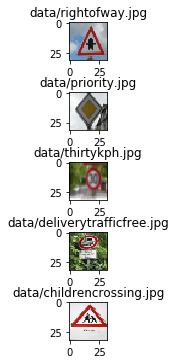

In [24]:
import skimage.io as ski
import skimage.filters as skf
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
new_image1 = "data/rightofway.jpg"
new_image2 = "data/priority.jpg"
new_image3 = "data/thirtykph.jpg"
new_image4 = "data/deliverytrafficfree.jpg"
new_image5 = "data/childrencrossing.jpg"
new_images = [new_image1, new_image2, new_image3, new_image4, new_image5]
processed_img = []
# load image
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(5,5))
fig.tight_layout()
for i in range(len(new_images)):
    n_img = ski.imread(new_images[i])
    # apply gaussian blur for resizing
    n_img = skf.gaussian(n_img, sigma=5, multichannel=True)
    # resize to 32,32,3
    n_img = skimage.transform.resize(n_img, (32,32), mode='reflect')
    processed_img.append(n_img)
    ax = plt.subplot(5,1,i+1)
    ax.set_title(new_images[i])
    plt.imshow(n_img)

### Predict the Sign Type for Each Image

In [26]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
# preprocess to desired model
# do predictions
# show probabilities
new_image_prediction = tf.argmax(logits, 1)
def get_prediction(X_data, y_data):
    sess = tf.get_default_session()
    return sess.run(new_image_prediction, feed_dict={x: np.expand_dims(X_data,axis=0), y: y_data, keep_prob: 1})

for i in range(len(new_images)):
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        n_img_equal = skimage.exposure.equalize_hist(skimage.color.rgb2grey(img_normalise(processed_img[i])))
        n_img_equal = n_img_equal.reshape(n_img_equal.shape + (1,)) 
        predictions = get_prediction(n_img_equal, y_valid[0])
        print(new_images[i],predictions, signnames[predictions[0]])

data/rightofway.jpg [11] ['11', 'Right-of-way at the next intersection']
data/priority.jpg [12] ['12', 'Priority road']
data/thirtykph.jpg [25] ['25', 'Road work']
data/deliverytrafficfree.jpg [26] ['26', 'Traffic signals']
data/childrencrossing.jpg [16] ['16', 'Vehicles over 3.5 metric tons prohibited']


### Analyze Performance

In [27]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [28]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

probs = tf.nn.softmax(logits)
def evaluate_probs(X_data, y_data):
    sess = tf.get_default_session()
    return sess.run(probs, feed_dict={x: np.expand_dims(X_data,axis=0), y: y_data, keep_prob: 1})

In [29]:
for i in range(len(new_images)):
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        n_img_equal = skimage.exposure.equalize_hist(skimage.color.rgb2grey(img_normalise(processed_img[i])))
        n_img_equal = n_img_equal.reshape(n_img_equal.shape + (1,)) 
        prob_array = evaluate_probs(n_img_equal, y_valid[0])
        values, indices = tf.nn.top_k(prob_array,3)
        print(sess.run(values))
        print(sess.run(indices))

[[  1.00000000e+00   3.95035775e-11   3.17703017e-11]]
[[11 18 30]]
[[  9.99774396e-01   1.47042403e-04   7.75528752e-05]]
[[12 29  7]]
[[ 0.98431545  0.00985702  0.00517091]]
[[25 37 10]]
[[  9.99993205e-01   3.02574222e-06   2.52288805e-06]]
[[26 22 39]]
[[ 0.8644312   0.09030361  0.01918409]]
[[16 39  0]]


### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [30]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    #activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

In [40]:
# open test image and feed into featureMap
output_type = tf.Variable('conv1')
logits = LeNet(x,keep_prob,output_type)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    n_img_equal = skimage.exposure.equalize_hist(skimage.color.rgb2grey(img_normalise(processed_img[0])))
    n_img_equal = n_img_equal.reshape(n_img_equal.shape + (1,)) 
    activation = 'conv1'
    activation = sess.run(logits, feed_dict={x: np.expand_dims(n_img_equal,axis=0), y: y_valid, keep_prob: 1, output_type: activation})
    print(activation.shape)
    #outputFeatureMap(n_img_equal,activation)

FailedPreconditionError: Attempting to use uninitialized value Variable_17
	 [[Node: Variable_17/read = Identity[T=DT_FLOAT, _class=["loc:@Variable_17"], _device="/job:localhost/replica:0/task:0/gpu:0"](Variable_17)]]
	 [[Node: add_9/_69 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_28_add_9", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'Variable_17/read', defined at:
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2683, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2787, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2847, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-40-18bfbcccb8b5>", line 3, in <module>
    logits = LeNet(x,keep_prob,output_type)
  File "<ipython-input-20-a66baf9d562d>", line 9, in LeNet
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 224, in __init__
    expected_shape=expected_shape)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 370, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1424, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value Variable_17
	 [[Node: Variable_17/read = Identity[T=DT_FLOAT, _class=["loc:@Variable_17"], _device="/job:localhost/replica:0/task:0/gpu:0"](Variable_17)]]
	 [[Node: add_9/_69 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_28_add_9", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]
